In [1]:
import os
import zipfile
import glob
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
#1️ Extract ZIP Files

image_zip = "RoadSeg2.v3i.700img_Original.zip"
label_zip = "RoadSeg2.v3i.700img_Masks.zip"

image_extract_dir = os.path.splitext(image_zip)[0]  
label_extract_dir = os.path.splitext(label_zip)[0]   

os.makedirs(image_extract_dir, exist_ok=True)
os.makedirs(label_extract_dir, exist_ok=True)

# Extract image zip
with zipfile.ZipFile(image_zip, "r") as z:
    z.extractall(image_extract_dir)

# Extract mask zip
with zipfile.ZipFile(label_zip, "r") as z:
    z.extractall(label_extract_dir)

print("Extraction complete!")

Extraction complete!


In [3]:
#2️ Dataset Paths
image_base = os.path.join(image_extract_dir, "images")
label_base = os.path.join(label_extract_dir, "masks_class3_white")

print("Image base:", image_base)
print("Label base:", label_base)

Image base: RoadSeg2.v3i.700img_Original\images
Label base: RoadSeg2.v3i.700img_Masks\masks_class3_white


In [4]:
#3️ Helper Functions

IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 50

# ---- Dataset functions (stronger augmentation) ----
def load_image_mask(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.per_image_standardization(img)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.float32) / 255.0
    # ensure binary mask (0 or 1)
    mask = tf.round(mask)
    return img, mask

def augment_image_mask(img, mask):
    # Data augmentation
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.2)
    return img, mask   

def create_dataset(image_dir, mask_dir, augment=False):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "**/*.jpg"), recursive=True))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "**/*.png"), recursive=True))

    print(f"Found {len(image_paths)} images and {len(mask_paths)} masks in {image_dir}")

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = (
    dataset
    .cache()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
    return dataset, len(image_paths), len(mask_paths)



In [5]:
#4️ Create Datasets

train_ds, train_count_img, _ = create_dataset(
    os.path.join(image_base, "train"),
    os.path.join(label_base, "train"),
    augment=True)

val_ds, val_count_img, _ = create_dataset(
    os.path.join(image_base, "valid"),
    os.path.join(label_base, "valid"),
    augment=False)

# fallback counts if glob didn't find files (safe)
train_count = train_count_img or 1
val_count = val_count_img or 1
steps_per_epoch = max(1, train_count // BATCH_SIZE)
validation_steps = max(1, val_count // BATCH_SIZE)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 549 images and 549 masks in RoadSeg2.v3i.700img_Original\images\train
Found 115 images and 115 masks in RoadSeg2.v3i.700img_Original\images\valid


In [6]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return (intersection + smooth) / (union + smooth)

In [7]:
#5 Define Simple U-N

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return models.Model(inputs, outputs)

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + 1e-7)
    return iou

model = unet_model()
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │         17 │ conv2d_7[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,705 (416.82 KB)

 Trainable params: 106,705 (416.82 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#6 Train Model

# ---- Fit ----
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

model.save("road_segmentation_unet700img.keras")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 980ms/step - accuracy: 0.7943 - iou_metric: 0.0229 - loss: 0.4199 - val_accuracy: 0.8693 - val_iou_metric: 0.0000e+00 - val_loss: 0.3918
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 953ms/step - accuracy: 0.8901 - iou_metric: 0.0022 - loss: 0.2219 - val_accuracy: 0.8744 - val_iou_metric: 0.0674 - val_loss: 0.4859
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 945ms/step - accuracy: 0.9145 - iou_metric: 0.3206 - loss: 0.1848 - val_accuracy: 0.8092 - val_iou_metric: 0.2951 - val_loss: 0.4419
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 972ms/step - accuracy: 0.9236 - iou_metric: 0.4249 - loss: 0.1721 - val_accuracy: 0.8496 - val_iou_metric: 0.2828 - val_loss: 0.4961
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 971ms/step - accuracy: 0.9308 - iou_metric: 0.4691 - loss: 0.1609 - val_accuracy: 0.8519 - val_iou_metric: 0.3119 - val_loss: 0.5110
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 965ms/step - accuracy: 0.9353 - iou_metric: 0.5046 - loss: 0.1517 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2396005..3.2999184].


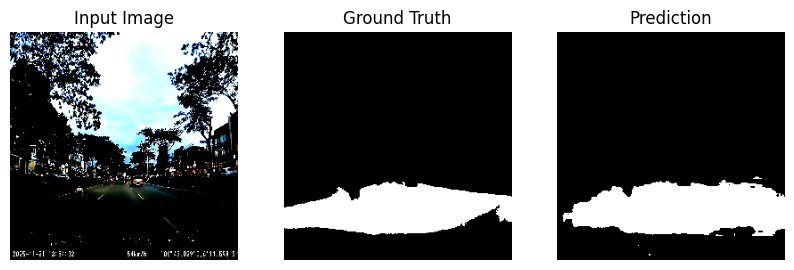

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7325456..7.1645546].


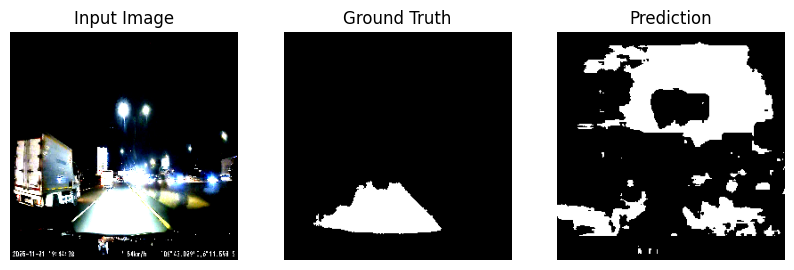

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88054..7.8616652].


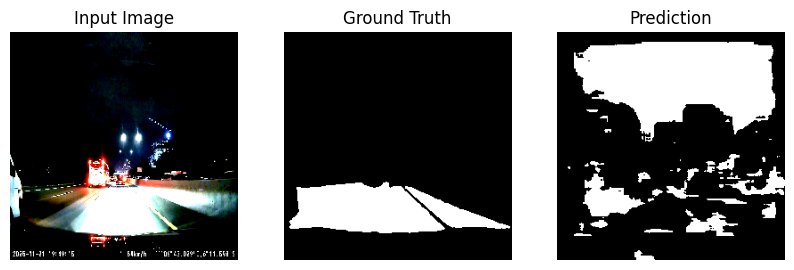

In [9]:
#7 Visualize Predictions

def display_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num):
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(tf.squeeze(preds[i] > 0.5), cmap='gray')
            plt.title("Prediction")
            plt.axis("off")
            plt.show()

display_predictions(val_ds, model)